In [39]:
import sys
import os
import matplotlib.pyplot as plt
import torch
import math
import numpy as np
from PIL import Image
import cv2
from pathlib import Path
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
sys.path.append(os.path.abspath("../src"))

In [7]:
from dataset import BinaryDenoisingDataset
from model import BinaryDenoisingAutoencoder
from train import train_model
from evaluation import evaluate_model, visualize_binary_results

### Train Model

In [27]:
binary_threshold = 0.5  # Threshold for binary output

# Define transformations for input images
transform = transforms.Compose([
    transforms.Resize((724, 512)),
    transforms.ToTensor()
])

# Load data
# Replace with your actual directories
noisy_dir = "/Users/volpea/Documents/projects/document-generator-job/data/sampling/document_19/"
clean_dir = "/Users/volpea/Documents/projects/document-generator-job/data/labels/document_19/"

# Create datasets with binary targets
full_dataset = BinaryDenoisingDataset(
    noisy_dir=noisy_dir, 
    clean_dir=clean_dir, 
    transform=transform,
    convert_to_binary=True,
    threshold=binary_threshold
)

# Split into train/val/test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=0)

# Initialize model
model = BinaryDenoisingAutoencoder(input_channels=3)

In [6]:
noisy_image = full_dataset[0][0]
clean_image = full_dataset[0][1]

In [7]:
noisy_image.shape

torch.Size([3, 724, 512])

In [8]:
clean_image.shape

torch.Size([1, 724, 512])

In [9]:
clean_image

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [10]:
noisy_image.shape

torch.Size([3, 724, 512])

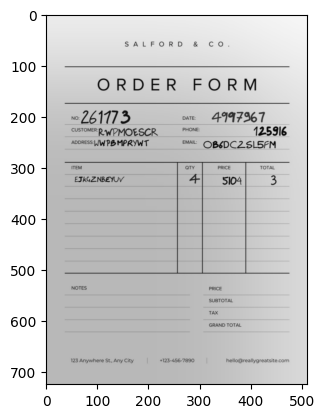

In [11]:
plt.imshow(noisy_image.numpy().transpose(1, 2, 0))
plt.show()

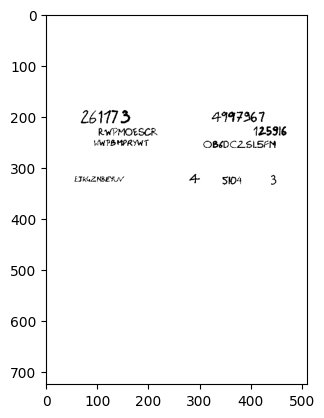

In [12]:
plt.imshow(clean_image.numpy().transpose(1, 2, 0), cmap="binary")
plt.show()

In [ ]:
# Hyperparameters
batch_size = 16
num_epochs = 10
learning_rate = 0.001

In [15]:
# Train model
model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, num_epochs=5, learning_rate=learning_rate
)

Epoch [1/5], Train Loss: 0.0584, Val Loss: 0.0327
Epoch [2/5], Train Loss: 0.0288, Val Loss: 0.0252
Epoch [3/5], Train Loss: 0.0239, Val Loss: 0.0217
Epoch [4/5], Train Loss: 0.0213, Val Loss: 0.0203
Epoch [5/5], Train Loss: 0.0189, Val Loss: 0.0177


In [18]:
# Train model
model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, num_epochs=5, learning_rate=learning_rate
)

Epoch [1/5], Train Loss: 0.0735, Val Loss: 0.0240
Epoch [2/5], Train Loss: 0.0212, Val Loss: 0.0188
Epoch [3/5], Train Loss: 0.0182, Val Loss: 0.0170
Epoch [4/5], Train Loss: 0.0170, Val Loss: 0.0159
Epoch [5/5], Train Loss: 0.0160, Val Loss: 0.0152


In [ ]:
# Plot training/validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('binary_training_losses.png')
plt.show()

In [110]:
# Save model
torch.save(model.state_dict(), 'binary_denoising_model.pth')

### Evaluation

In [28]:
# Load Model
model.load_state_dict(torch.load("binary_denoising_model.pth", weights_only=True))

<All keys matched successfully>

using_device: mps
Test Loss: 0.0152, Test Accuracy: 0.9932


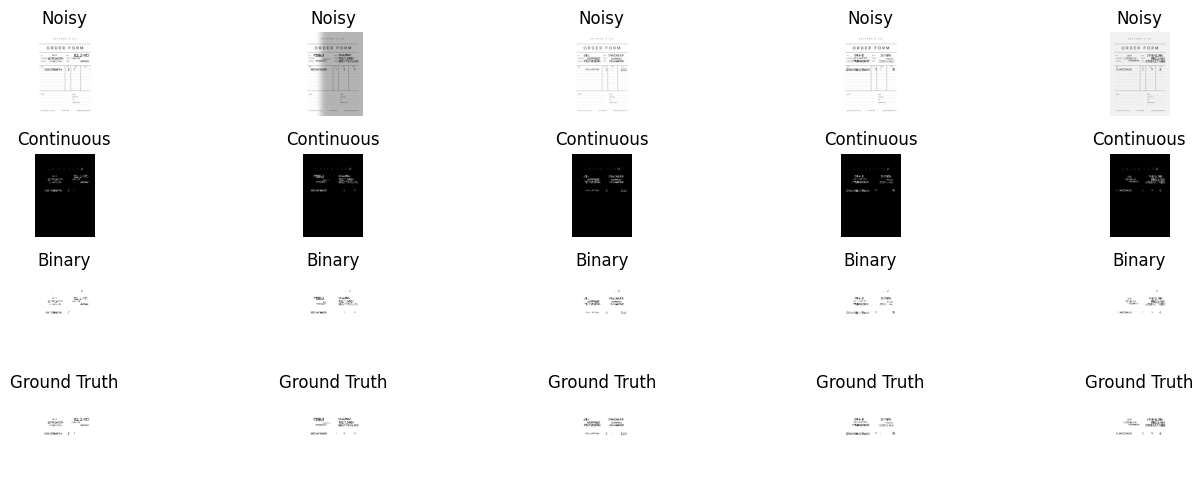

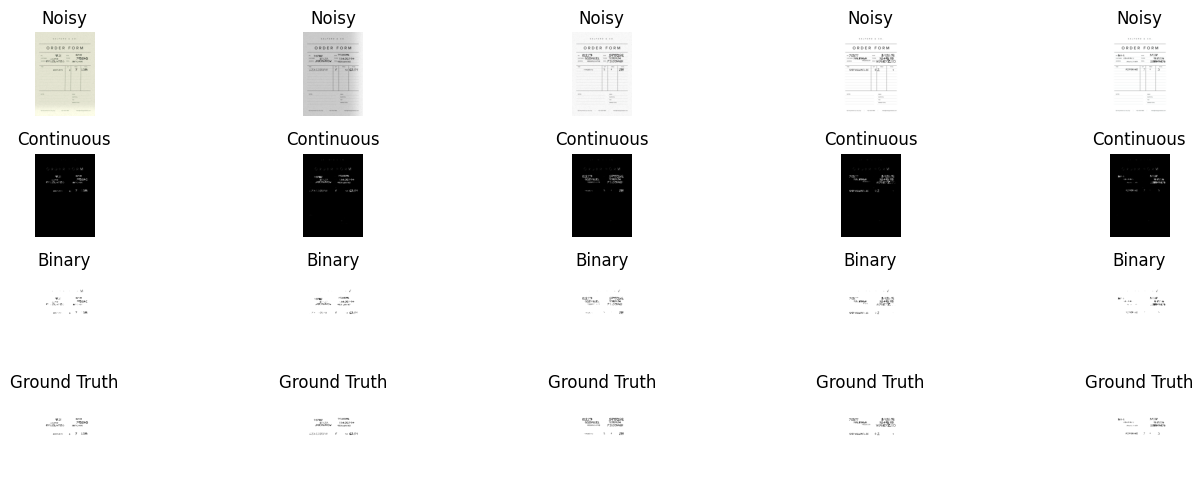

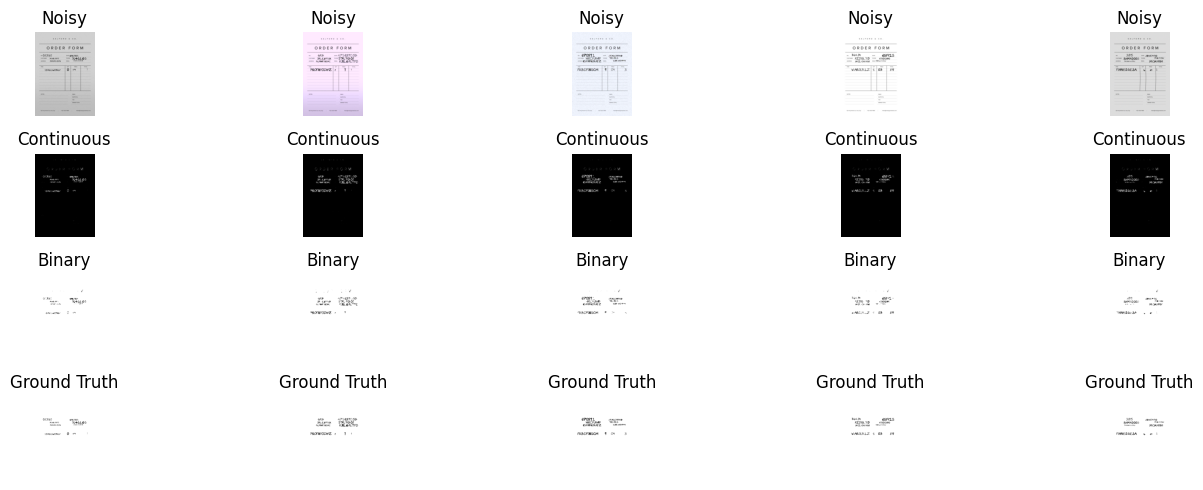

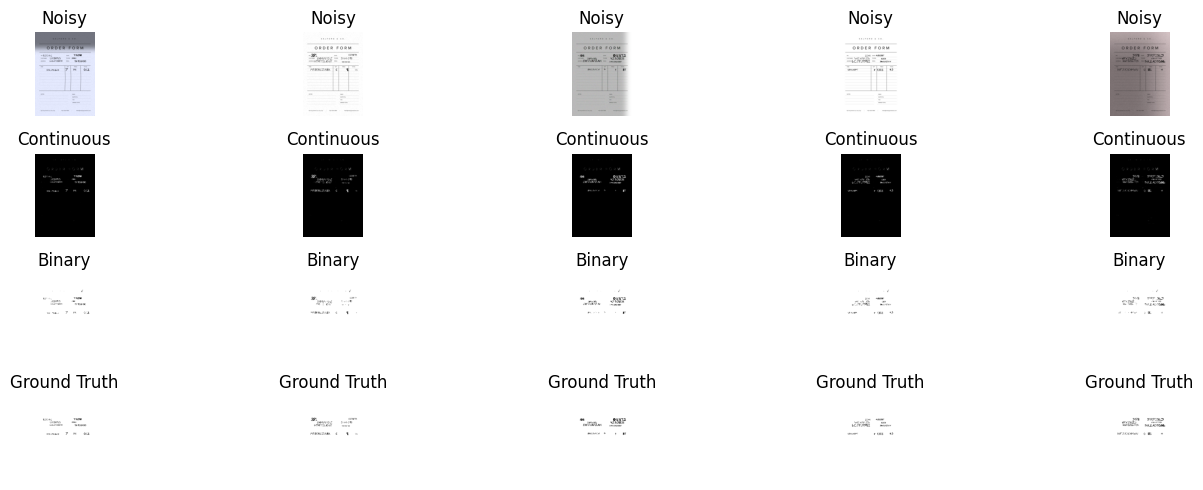

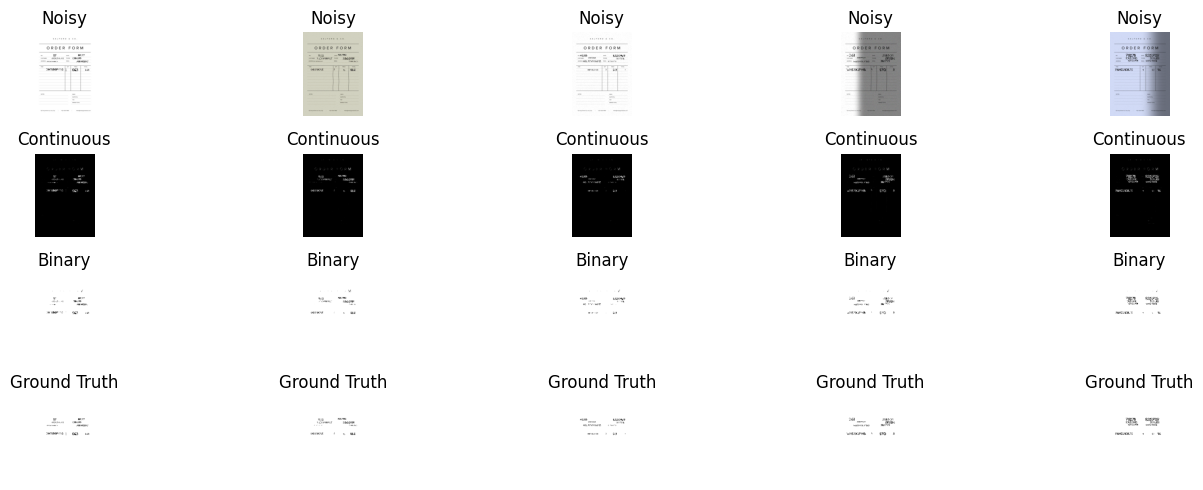

In [30]:
# Evaluate model
test_loss, test_accuracy = evaluate_model(model, test_loader, threshold=binary_threshold)

# Visualize results
visualize_binary_results(model, test_loader, threshold=binary_threshold)

In [73]:
def predict_image(noisy_image, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    noisy_image = noisy_image.to(device)
    
    with torch.no_grad():
        prediction = model(noisy_image)

    return prediction.cpu().numpy()

In [74]:
noisy_image = test_loader.dataset[0][0]

In [76]:
predicted_image = predict_image(noisy_image, model)

In [77]:
predicted_image_binary = (predicted_image > binary_threshold)

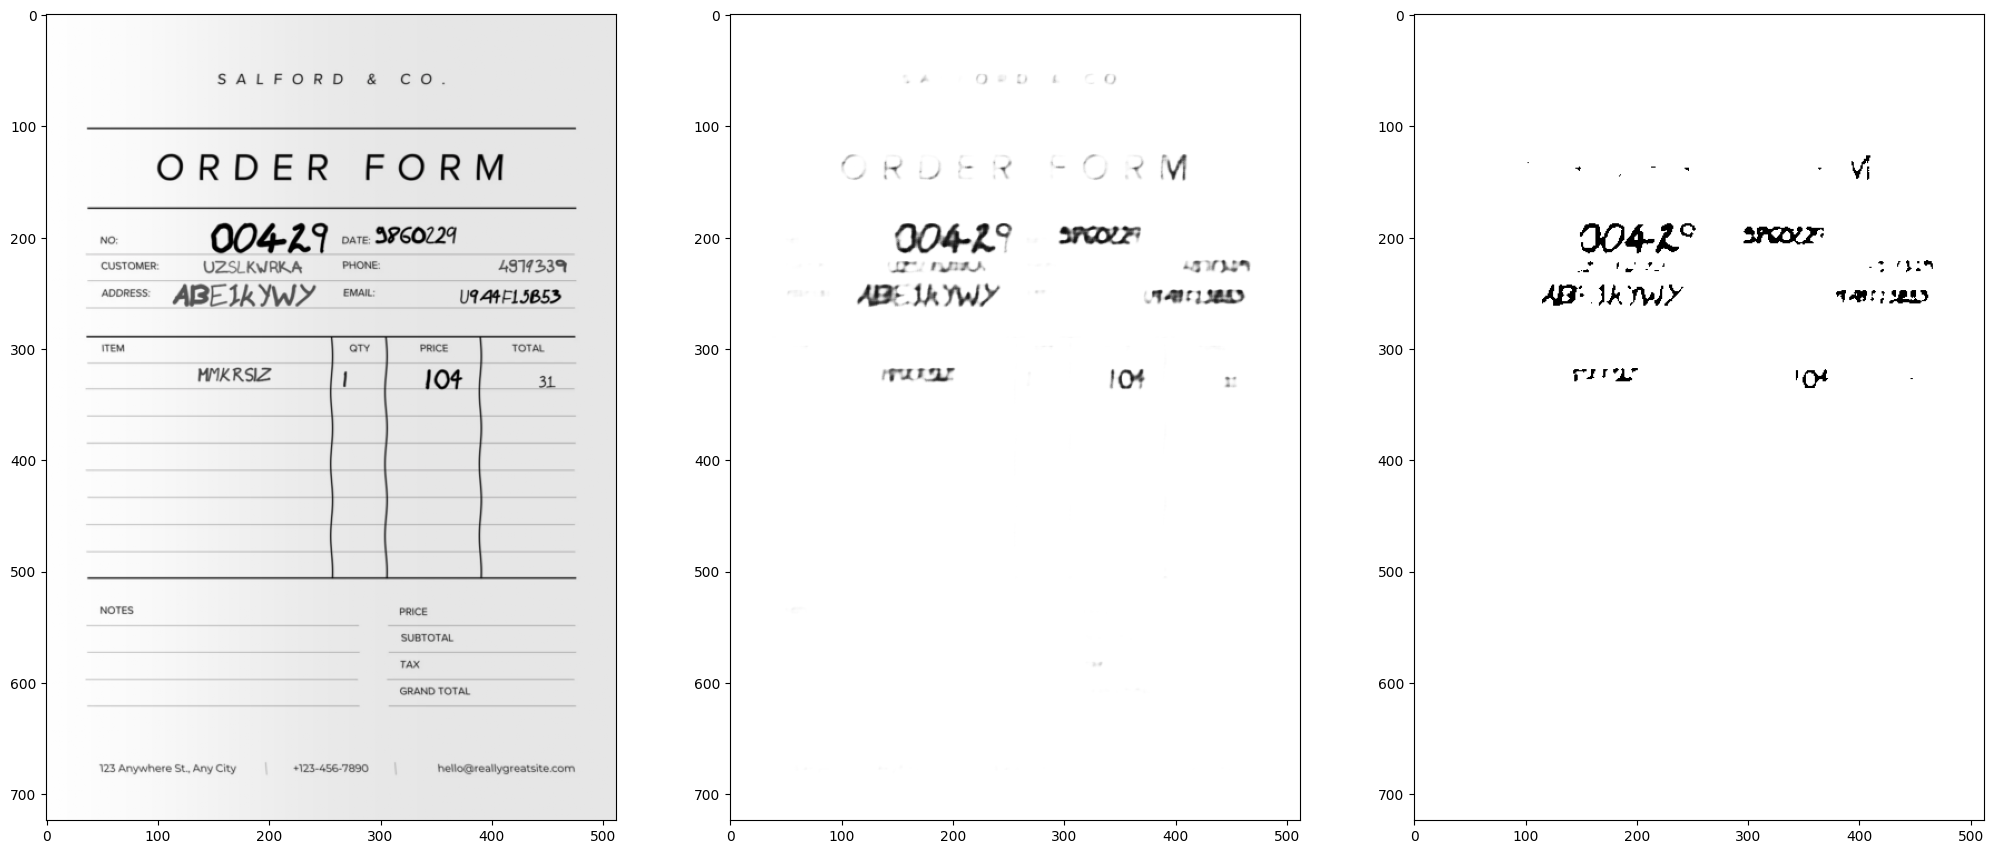

In [79]:
fig, ax = plt.subplots(ncols=3, figsize=(25, 15))
ax[0].imshow(noisy_image.numpy().transpose(1, 2, 0))
ax[1].imshow(1 - predicted_image[0], cmap="gray", vmin=0, vmax=1)
ax[2].imshow(predicted_image_binary[0], cmap="binary")
plt.show()

### Test Real Image

In [43]:
def align_to_template(image, template):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    orb = cv2.SIFT_create(500)
    keypoints1, descriptors1 = orb.detectAndCompute(image_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(template_gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_SL2)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches = sorted(matches, key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    num_good_matches = int(len(matches) * 0.15)
    matches = matches[:num_good_matches]

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width = template_gray.shape
    registered_image = cv2.warpPerspective(image, h, (width, height))

    return registered_image

In [44]:
image = cv2.imread("/Users/volpea/Documents/projects/document-generator-job/data/test/example_form_real_1.jpg")
template = cv2.imread("/Users/volpea/Documents/projects/document-generator-text-extractor/data/templates/example_form_template.webp")

In [45]:
registered_image = align_to_template(image, template)

In [52]:
registered_image = Image.fromarray(cv2.cvtColor(registered_image, cv2.COLOR_BGR2RGB))

In [56]:
input_image = transform(registered_image)

In [60]:
predicted_image = predict_image(input_image, model)

In [64]:
predicted_image_binary = (predicted_image > binary_threshold)

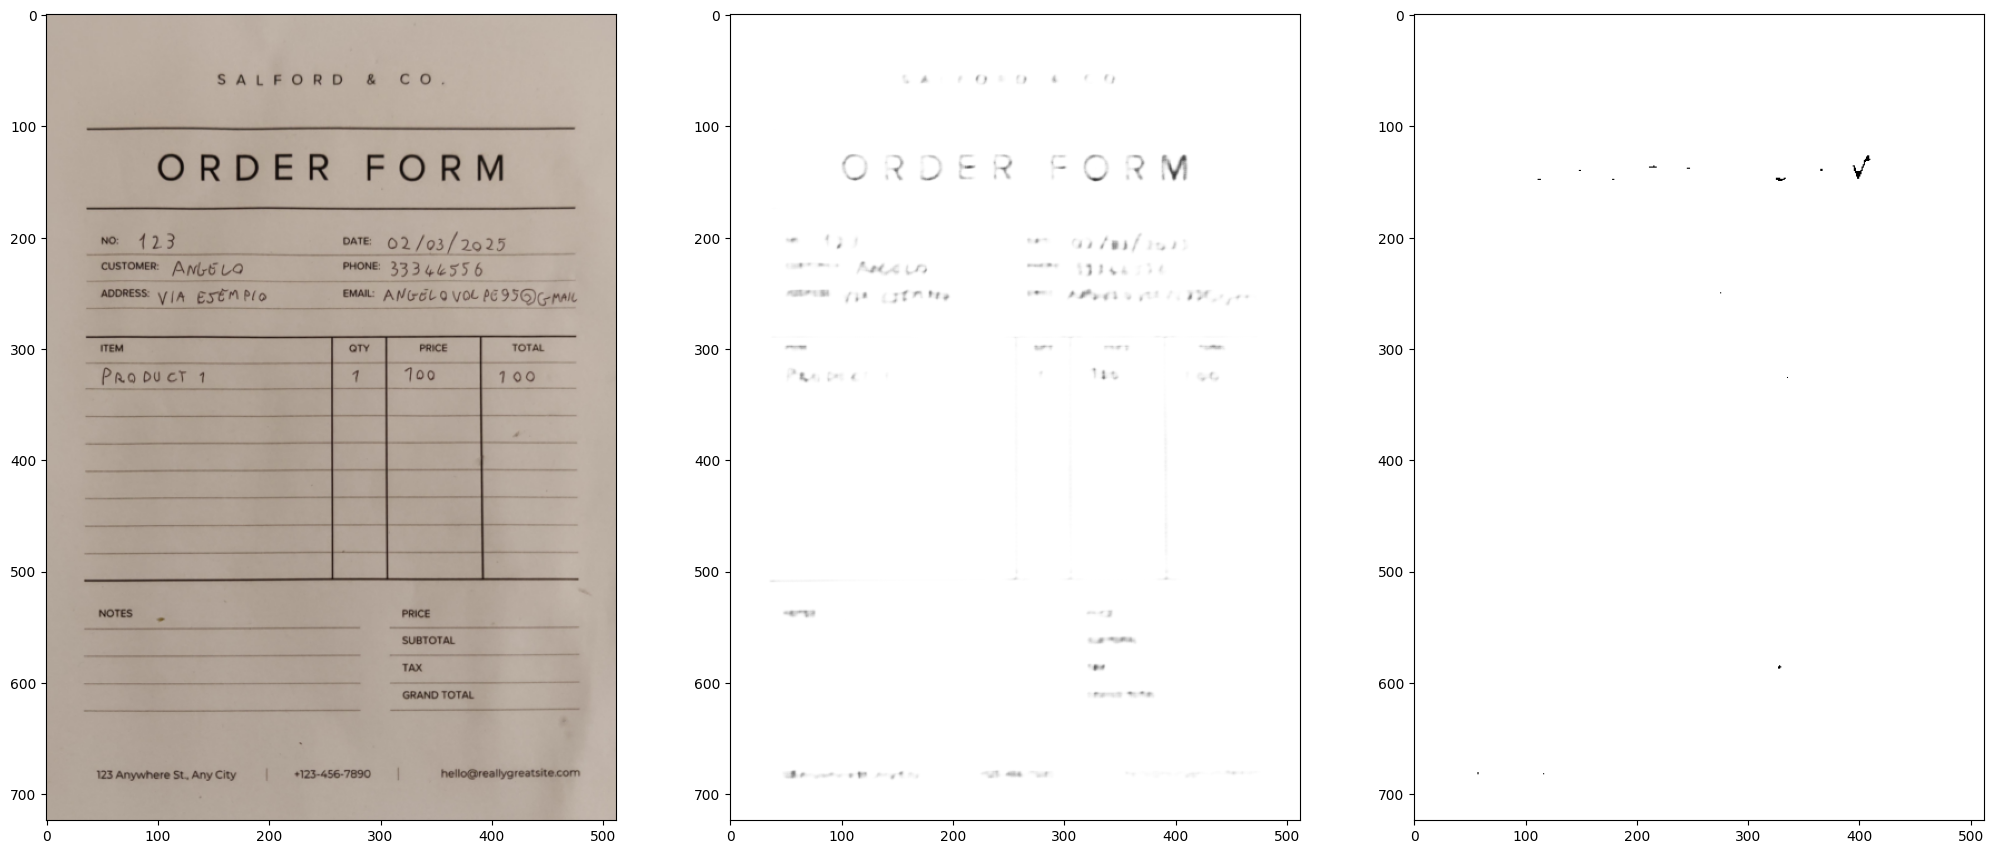

In [72]:
fig, ax = plt.subplots(ncols=3, figsize=(25, 15))
ax[0].imshow(input_image.numpy().transpose(1, 2, 0))
ax[1].imshow(1 - predicted_image[0], cmap="gray", vmin=0, vmax=1)
ax[2].imshow(predicted_image_binary[0], cmap="binary")
plt.show()